In [2]:
# https://scikit-learn.org/stable/modules/permutation_importance.html

In [3]:
!pip install -q scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [4]:
# Misc
RANDOM_STATE = 42

In [5]:
import json
import os

import joblib  # https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from skopt import BayesSearchCV

# Data splitting

In [6]:
!gdown --fuzzy https://drive.google.com/file/d/17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ
To: /content/cleaned_bmarket.csv
100% 2.65M/2.65M [00:00<00:00, 25.9MB/s]


In [7]:
df = pd.read_csv("./cleaned_bmarket.csv")

In [8]:
y = df["Subscription Status"]
X = df.drop("Subscription Status", axis=1)
X = pd.get_dummies(X, drop_first=True)  # PLEASE rememeber to research label encoder >.<

In [9]:
print(X.shape, y.shape)

(40787, 26) (40787,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Misc

In [11]:
class ModelWrapper:
    def __init__(self, title, model, hyperparameters, param_grid, cv, n_iterations=50):
        self.title = title
        self.model = model(**hyperparameters)
        self.param_grid = param_grid
        self.cv = cv
        self.n_iterations = n_iterations

        self.best_epoch = None
        self.best_params = None
        self.best_model = None

    def run_gridsearch(self, X, y):
        gs = GridSearchCV(
            estimator=self.model,
            param_grid=self.param_grid,
            cv=self.cv,
            scoring="f1",
            n_jobs=-1,
            verbose=2,
            return_train_score=True,
        )

        gs.fit(X, y)  # PLSSSS TRAINNNNNN :3

        self.best_params = gs.best_params_
        self.best_model = gs.best_estimator_
        if hasattr(gs.best_estimator_, "n_estimators"):
            self.best_epoch = gs.best_estimator_.n_estimators
        else:
            self.best_epoch = getattr(gs.best_estimator_, "n_iter_")

    def run_bayessearch(self, X, y):
        bs = BayesSearchCV(
            estimator=self.model,
            search_spaces=self.param_grid,
            cv=self.cv,
            scoring="f1",  # Due to class imbalance
            n_jobs=-1,
            verbose=2,
            return_train_score=True,
            n_iter=self.n_iterations,
        )

        bs.fit(X, y)

        self.best_params = bs.best_params_
        self.best_model = bs.best_estimator_
        if hasattr(bs.best_estimator_, "n_estimators"):
            self.best_epoch = bs.best_estimator_.n_estimators
        else:
            self.best_epoch = getattr(bs.best_estimator_, "n_iter_")

    def write_info_to_disk(self, X, y, folder_path):
        save_dir = os.path.join(folder_path, self.title)
        os.makedirs(save_dir, exist_ok=True)

        model_path = os.path.join(save_dir, f"{self.title}.pkl")
        joblib.dump(self.best_model, model_path)

        params_path = os.path.join(save_dir, "parameters.json")
        with open(params_path, "w") as f:
            json.dump(self.best_params, f, indent=4)

        y_pred = self.best_model.predict(X)

        cm = confusion_matrix(y, y_pred)

        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        labels = ["False", "True"]
        plt.title(f"Confusion Matrix: {self.title}")
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")

        plot_path = os.path.join(save_dir, "cmatrix.png")
        plt.savefig(plot_path)
        plt.close()

        test_error = pd.concat([measure_error(y, y_pred, "test")], axis=1)
        test_error.to_csv(os.path.join(save_dir, "test_error.csv"))

In [12]:
###################
# Hyperparameters #
###################

from skopt.space import Categorical, Integer, Real

# Random Forest: {
rf_params = {
    "n_jobs": 1,
    "oob_score": True,
    "warm_start": False,
    "random_state": RANDOM_STATE,
}

# rf_gs_params = {
#     "max_features": ["log2"],
#     "min_samples_split": [2, 5, 10],
#     'max_samples': [0.75, None,],
#     "class_weight": ["balanced", None],
#     "max_depth": [20, None],
#     "n_estimators": [1500, 2000],
# }

rf_bayes_params = {
    "max_features": Categorical(["sqrt", "log2"]),
    "min_samples_split": Integer(2, 25),
    "max_samples": Real(0.5, 1.0),
    "class_weight": Categorical(["balanced", None]),
    "max_depth": Integer(10, 100),
    "n_estimators": Integer(200, 1000),
}
# }

In [13]:
def measure_error(y_true, y_pred, label):
    return pd.Series(
        {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "f1": f1_score(y_true, y_pred),
        },
        name=label,
    )

# Ensemble models

### Random Forest

**Optimization Methods**


*   Grid Search
*   Adjusting decision threshold

Only boosting trees plot training and validation loss


In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf_ens = ModelWrapper(
    title="RandomForestClassifier",
    model=RandomForestClassifier,
    hyperparameters={**rf_params},
    param_grid={**rf_bayes_params},
    cv=2,
    n_iterations=5,
)

In [16]:
clfs = [rf_ens]

In [17]:
for model in clfs:
    model.run_bayessearch(X_train, y_train)
    model.write_info_to_disk(X_test, y_test, "/content")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [18]:
pd.read_csv("./RandomForestClassifier/test_error.csv")

,Unnamed: 0,test
0,accuracy,0.812944
1,precision,0.289090
2,recall,0.452666
3,f1,0.352841


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = rf_ens.best_model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

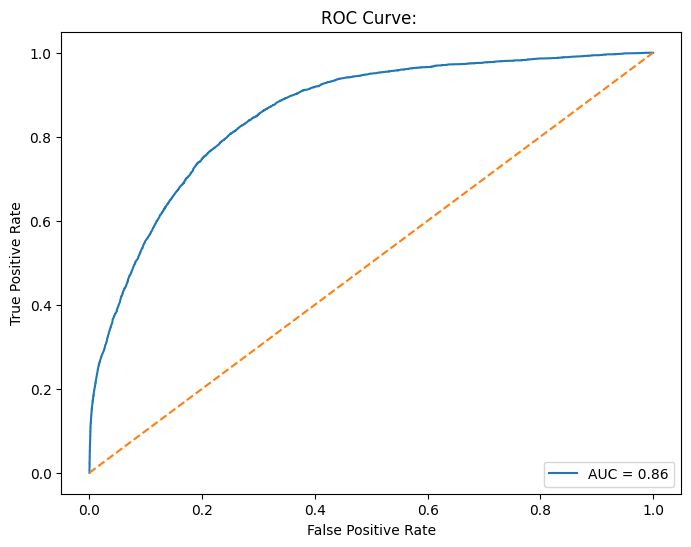

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: ")
plt.legend(loc=4)
plt.show()

In [21]:
import numpy as np

/tmp/ipython-input-1616374749.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_numeric = y.replace(True, 1).replace(False, 0).astype(int)


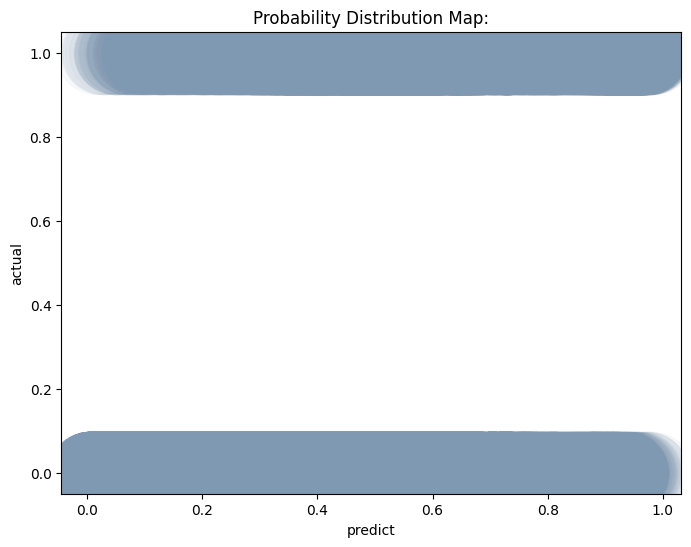

In [22]:
y_scores = rf_ens.best_model.predict_proba(X)[:, 1]
if hasattr(y, "replace"):
    y_numeric = y.replace(True, 1).replace(False, 0).astype(int)
else:
    y_numeric = y.astype(int)
dist_df = pd.DataFrame({"actual": y_numeric, "predict": y_scores})
color = np.array([0.5, 0.6, 0.7]).reshape(1, -1)
ax = dist_df.plot.scatter(
    x="predict", y="actual", s=3500, alpha=0.05, figsize=(8, 6), c=color
)
plt.title("Probability Distribution Map:")
plt.show()

In [26]:
y_probs = rf_ens.best_model.predict_proba(X_test)[:, 1]

threshold = 0.53
y_pred_shifted = (y_probs >= threshold).astype(int)

In [27]:
new_recall = recall_score(y_test, y_pred_shifted)
new_precision = precision_score(y_test, y_pred_shifted)

print(f"{new_recall:.2f}")
print(f"{new_precision:.2f}")

print(confusion_matrix(y_test, y_pred_shifted))

0.42
0.32
[[6405  834]
 [ 530  389]]


In [28]:
f1_shifted = f1_score(y_test, y_pred_shifted)
print(f1_shifted)

0.36321195144724555
